# **Using Time of Day to Predict the Number of Simultaneous PLAIcraft Players: A KNN regression Analysis**

## **Introduction**
PLAICraft is a Minecraft server created by the Pacific Laboratory for Artificial Intelligence (PLAI) which serves as a research platform for studying the applications of artificial intelligence in the context of video games. However, managing this large-scale project is not a straightforward task: one key issue that the PLAI research team faces is ensuring that they have a sufficient number of licenses and the proper server hardware to accommodate a growing number of players.

Therefore, the objective of this DSCI100 project is to use PLAICraft data to predict the usage of the server in order to understand factors influencing player behavior and server load. Specifically, this project aims to investigate the following research question:  

*Can time of day accurately predict the number of simultaneous PLAIcraft players using KNN regression?*

KNN regression is a predictive tool that uses the K-nearest neighbours algorithm to predict a numerical response variable value for a new observation based on the values of the response variable for similar observations in a data set of past observations. In regression, the response variable is a numeric target outcome that is influenced by one or more explanatory variables, which are inputs used to make predictions about the response variable. 

Time of day was selected as the one explanatory variable of interest in this project because it is most directly associated with the PLAI researchers' overarching goal of determining what time windows are most likely to have largest numbers of concurrent players. The response variable, number of simultaneous PLAIcraft players, is a measure that reflects player demand at any given time of day and serves as an indicator of the required server capacity and licenses. 

In order to effectively address our research question, it is important to first understand the structure and content of the PLAIcraft data. 
The PLAIcraft data consists of two files: players.csv and sessions.csv.

**Table 1. players.csv (196 observations, 9 variables)**
|Variable | Variable type | Description | Issues|
|---|---|---|---|
|experience|chr|Self-ranked Minecraft skill level|Should be “fct" data type, players may overestimate/underestimate skill level<br>★| 
|subscribe|lgl|Whether player subscribed for server activity email updates| Players may have device notifications disabled|
|hashedEmail|chr|Account email in hashed format|One player may sign-up multiple times using different emails|
|played_hours|dbl|Total gameplay hours|Includes “away-from-keyboard” time|
|name|chr|Player username|N/A|
|gender|chr|Gender identity|Should be “fct” data type <br>★|
|age|dbl|Age in years|Only ages 7-99 can participate <br>★|
|individualID|lgl|Unique player identifier for anonymous data tracking|Data missing, cannot analyze|
|organizationName|lgl|Name of organization player is affiliated with|Data missing, cannot analyze|

★ Players may answer dishonestly or answers may not reflect changes made since their account creation.<br><br>

**Table 2. sessions.csv (1535 observations, 5 variables)**
|Variable Name|Variable type|Description|Potential Issues|
|---|---|---|---|
|hashedEmail|chr|Account email in hashed format|One player may sign-up multiple times using different emails|
|start_time|chr|Timestamp, player logging into PLAIcraft (day:month:year  hour:minute:second)|Not tidy, improper data type|
|end_time|chr|Timestamp, player exiting PLAIcraft (day:month:year  hour:minute:second)|Same as start_time|
|original_start_time|dbl|Start time, UNIX timestamp format|Not easily human readable, limited precision|
|original_end_time|dbl|End time, UNIX timestamp format|Same as original_start_time|


For the purposes of our analysis
For the purposes of our analysis, we will focus solely on the sessions.csv file. This file contains the key variables we need, including the start and end times, 

Start and end times are only in sessions.csv, so we will load but will not tidy and wrangle players.csv. From sessions.csv, we will extract "time_in_hours_past_midnight" from start_time and end_time in “dbl” format for analysis. We will remove original_start_time and original_end_time as UNIX timestamps are less precise and hashedEmail since we are not analyzing individual players.

Start and end times are only in sessions.csv, so we will load but will not tidy and wrangle players.csv. From sessions.csv, we will extract "time_in_hours_past_midnight" from start_time and end_time in “dbl” format for analysis. We will remove original_start_time and original_end_time as UNIX timestamps are less precise and hashedEmail since we are not analyzing individual players.

## **Methods and Results**

In [2]:
# Loading necessary libraries
library(tidyverse)
library(repr)
library(lubridate)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [5]:
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
players_data <- read_csv(players_url)
players_data

sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
sessions_data <- read_csv(sessions_url)
sessions_data

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19,NA,NA
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,NA,NA
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17,NA,NA


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,15/04/2024 07:12,15/04/2024 07:21,1.71317e+12,1.71317e+12
ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,21/09/2024 02:13,21/09/2024 02:30,1.72688e+12,1.72689e+12
96e190b0bf3923cd8d349eee467c09d1130af143335779251492eb4c2c058a5f,21/06/2024 02:31,21/06/2024 02:49,1.71894e+12,1.71894e+12


In [5]:
# Tidying and wrangling the sessions.csv data

active_player_counts <- sessions_data |>

    # Converting non-UNIX timestamps to standard dttm format
    mutate(start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M"),
           end_time = as.POSIXct(end_time,format = "%d/%m/%Y %H:%M")) |>

    # Selecting relevant columns
    select(start_time, end_time) |>

    # Counting the number of occurrences of each combination of actions (entry or exit) at each time point 
    pivot_longer(cols = c(start_time, end_time),
                names_to = "action",
                values_to = "time") |>
    
    drop_na(time) |>

    mutate(action = case_when(
          action == "start_time" ~ "entry",
          action == "end_time" ~ "exit")) |>

    group_by(time, action) |>
    summarize(count = n(), .groups = "drop") |>

    # Finding running total number of players at each timestamp
    pivot_wider(names_from = action, 
                values_from = count,
                values_fill = 0) |>

    mutate(total_active_players = cumsum(entry) - cumsum(exit))


# Extracting hours, minutes, and seconds from timestamp (time) and converting to "time_in_hours_past_midnight" 
# to make tidy for the purposes of this analysis
player_counts_by_time <- active_player_counts |>
    mutate(hour = hour(time),
           minute_in_hours = minute(time)/60,
           second_in_hours = second(time)/3600,
                                          
           time_in_hours_past_midnight = hour + minute_in_hours + second_in_hours) |>

    select(time_in_hours_past_midnight, total_active_players)


player_counts_by_time

time_in_hours_past_midnight,total_active_players
<dbl>,<int>
9.4500000,1
9.5166667,0
9.5833333,1
10.2666667,0
20.9333333,1
22.0666667,0
22.4000000,1
23.5500000,0
0.2833333,1


In [4]:
# Visualizing total active players by time of day

options(repr.plot.width = 8, repr.plot.height = 8)

sessions_plot <- player_counts_by_time |>
    ggplot(aes(x = time_in_hours_past_midnight, y = total_active_players)) +
    geom_point(alpha = 0.4) +
    labs(x = "Time of day (hours past midnight)",
         y = "Total active players",
         title = "Number of active PLAIcraft players by time of day") +
    scale_y_continuous(breaks = seq(0, max(player_counts_by_time), by = 1)) +
    theme(text = element_text(size = 15))

           
sessions_plot

ERROR: Error in eval(expr, envir, enclos): object 'player_counts_by_time' not found


In [ ]:
#KNN regression Data Analysis

#Part 0: Setting Seed value for reproducibility 
set.seed(1)

#Part 1: Splitting player_counts_by_time data frame into training and test sets respectively
player_counts_by_time_split<-initial_split(player_counts_by_time, prop = 0.70, strata = total_active_players)

#Converting training set and test set as data frames
player_counts_by_time_train <- training(player_counts_by_time_split)
player_counts_by_time_test <- testing(player_counts_by_time_split)

In [ ]:
#Part 2: Preparation of cross validation by subsetting training data into 5 folds with their own training/validation set
players_vfold <- vfold_cv(player_counts_by_time_train, v = 5, strata = total_active_players)

In [ ]:
#Part 3: Data Pre-processing (Selecting predictor and response variables)
players_recipe<- recipe(total_active_players ~ time_in_hours_past_midnight, data = player_counts_by_time_train)

In [ ]:
#Part 4: Model Specification to determine optimal K value
players_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("regression")

In [ ]:
#Part 5: Creating data frame with K-values to be evaluated to determine the optimal K value 
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

In [ ]:
#Part 6: Setting up of Workflow 
workflow_players <- workflow() |>
add_recipe(players_recipe) |>
add_model(players_spec_tune)

In [ ]:
#Part 7: Cross Validation Process 
players_results <- workflow_players |>
tune_grid(resamples = players_vfold, grid = k_vals) |>
collect_metrics() |>
filter(.metric == "rmse")

In [ ]:
#Part 8: Select for Best K value
best_K_val <- players_results |>
arrange(mean) |>
slice_min(mean, n = 1) |>
pull(neighbors)
best_K_val

In [ ]:
#Part 9: Generating New Model Specification with optimal K value
players_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = best_K_val) |>
set_engine("kknn") |>
set_mode("regression")

In [ ]:
#Part 10: Retraining Regression Model with new model specification
player_fit<- workflow() |>
add_model(players_spec_final) |>
add_recipe(players_recipe) |>
fit(data = player_counts_by_time_train)

In [ ]:
#Part 11: Prediction on Test Data and RMSPE value for model
players_prediction <- predict(player_fit, player_counts_by_time_test) |>
bind_cols(player_counts_by_time_test) |>
metrics(truth = total_active_players, estimate = .pred) |>
filter(.metric == "rmse")
players_prediction

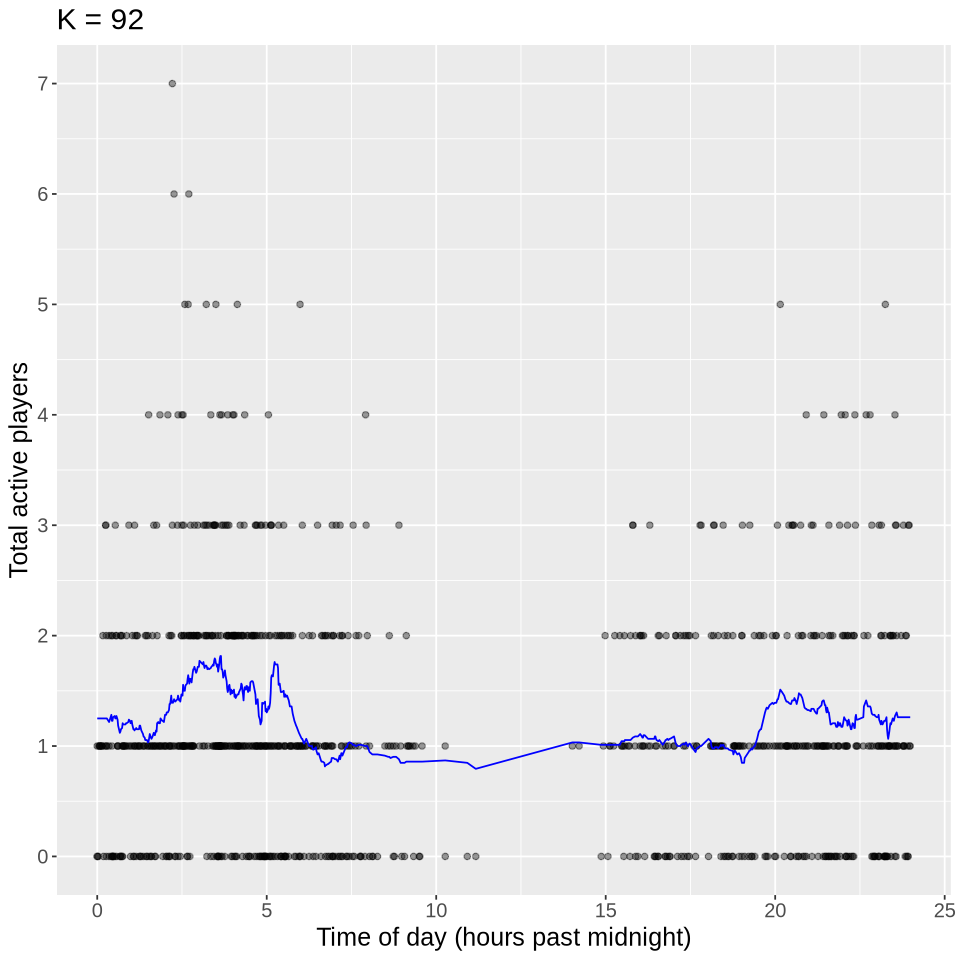

In [31]:
#Part 12: Visualization of KNN regression model
players_pred <- predict(player_fit, player_counts_by_time_test) |>
bind_cols(player_counts_by_time_test)


regression_pred_visual <- players_pred |>
ggplot(aes(x = time_in_hours_past_midnight, y = total_active_players)) +
geom_point(alpha = 0.4) +
geom_line(data = players_pred,
          mapping = aes(x = time_in_hours_past_midnight, y = .pred),
          color = "blue") +
labs(x ="Time of day (hours past midnight)",
     y = "Total active players",
     title = "K = 92") +
scale_y_continuous(breaks = seq(0, max(player_counts_by_time), by = 1)) +
theme(text = element_text(size = 15))
regression_pred_visual

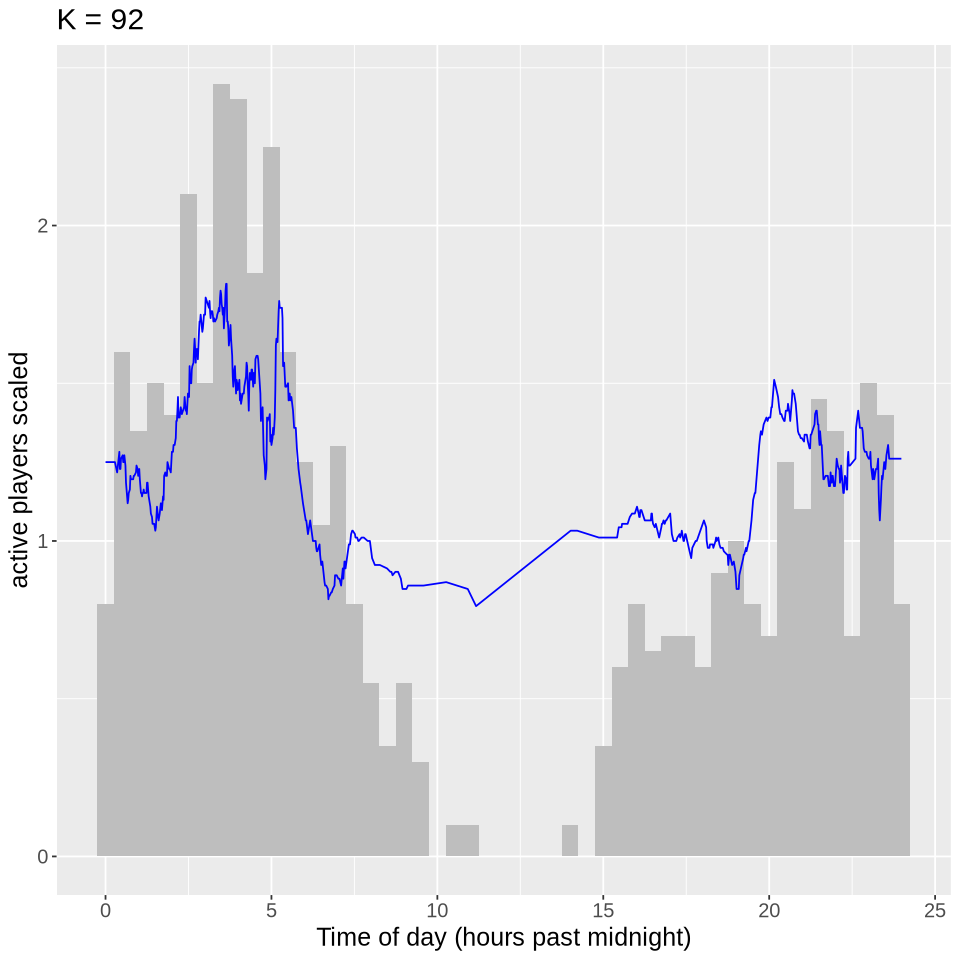

In [34]:
#Part 13: Further Visualization of KNN regression model
players_pred <- predict(player_fit, player_counts_by_time_test) |>
bind_cols(player_counts_by_time_test)


regression_pred_visual <- players_pred |>
ggplot(aes(x = time_in_hours_past_midnight)) +
geom_histogram(binwidth = 0.5, aes(y = ..count.. *0.05), fill = "gray") +
geom_line(data = players_pred,
          mapping = aes(x = time_in_hours_past_midnight, y = .pred),
          color = "blue") +
labs(x ="Time of day (hours past midnight)",
     y = "active players scaled",
     title = "K = 92") +
scale_y_continuous(breaks = seq(0, max(player_counts_by_time), by = 1)) +
theme(text = element_text(size = 15))
regression_pred_visual


# Discussion
## What We have Found


## Impact 

## Limitations, Future Questions and Further Research

A key limitaiton is that we are only assesssing one explanatory variable: time of day. We have neglected to account for day-of-the-week and seasonal trends which can also influence the number of simultaneous active players.


**Data Analysis, Visualization**<br>
Plot shows strong cyclical pattern: active player count is highest late at night/very early in morning with peaks between ~2.5-6 and ~20-23 hours past midnight. Least amount of players present 10-15 hours past midnight.<br>

**Methods/Plan**<br>
*Method:*
- KNN regression

*Rationale/model selection:*
- Numerical response variable: regression chosen over classification
- Non-linear data pattern: KNN regression more appropriate than linear regression

*Assumptions:*
- Points closer to each other are more similar to each other

*Limitations:*
- **Need to account for cyclical nature of time** via sin() and cos() transformations (0 and 23.99 hours-past-midnight should be considered adjacent in time rather than at extreme ends of linear scale like in graph)
- Less accurate extrapolations for times with less data

*Processing:*
- Standardization not needed (Only one predictor: time_in_hours_past_midnight)
- Split data before training: 70% training, 30% testing
- Tuning: best “K”  determined via minimum RMSE of 5-fold cross-validation of training set (model trained on ⅘, validated on ⅕) with different k-values (1-100)
- Model re-trained with ideal K (training set)
- Performance evaluated using test set after training (RMSPE)


#### Group Member Contributions

|Name|Contribution|
|---|---|
|Adam Abdirahman Hassan|Code for KNN regression analysis and visualization; explanatation of code for KNN regression analysis|
|Alexandra Mykitiuk|Introduction; code for tidying, wrangling, and initial visualization of the data (retrieved from individual report); explanation of the code for tidying, wrangling and initial visualization of the data; editing of code explanation for KNN regression analysis|